<a href="https://colab.research.google.com/github/joshuabusinge/SplitAgentDeposit-Fraud/blob/main/SplitAgentDepositML_Fraud_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, matthews_corrcoef, make_scorer,
    confusion_matrix
)
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# read data
df = pd.read_csv('/content/drive/MyDrive/MASTERS_DEGREE/Makerere_Unversity/Project Data/MoMTSim_20230525133535_1000_rawLog.csv')
df.head()

,0,DEPOSIT,19414.74,4.22142E+15,97.59,19512.33,76-0004369,0.1,0.2,1,0.3,0.4,0.5
0,0,DEPOSIT,23939.39,4.629230e+15,4925.03,28864.42,76-0004369,0.0,0.0,1,0,0,0
1,0,DEPOSIT,23288.45,4.734790e+15,72.37,23360.82,76-0004369,0.0,0.0,1,0,0,0
2,0,DEPOSIT,23210.04,4.734790e+15,23360.82,46570.86,76-0004369,0.0,0.0,1,0,0,0
3,0,DEPOSIT,23193.08,4.868780e+15,43.00,23236.09,76-0004369,0.0,0.0,1,0,0,0
4,0,DEPOSIT,19029.53,4.218830e+15,86.30,19115.83,76-0004369,0.0,0.0,1,0,0,0


In [4]:
# Assign column names
df.columns = ['step','transaction_type','amount','nameOrig','oldBalStartingClient','newBalStartingClient','nameDest','oldBalDestClient','newBalDestClient','isFraud','isFlaggedFraud','isUnauthorizedOverdraft','unnamed']

df.head()

,step,transaction_type,amount,nameOrig,oldBalStartingClient,newBalStartingClient,nameDest,oldBalDestClient,newBalDestClient,isFraud,isFlaggedFraud,isUnauthorizedOverdraft,unnamed
0,0,DEPOSIT,23939.39,4.629230e+15,4925.03,28864.42,76-0004369,0.0,0.0,1,0,0,0
1,0,DEPOSIT,23288.45,4.734790e+15,72.37,23360.82,76-0004369,0.0,0.0,1,0,0,0
2,0,DEPOSIT,23210.04,4.734790e+15,23360.82,46570.86,76-0004369,0.0,0.0,1,0,0,0
3,0,DEPOSIT,23193.08,4.868780e+15,43.00,23236.09,76-0004369,0.0,0.0,1,0,0,0
4,0,DEPOSIT,19029.53,4.218830e+15,86.30,19115.83,76-0004369,0.0,0.0,1,0,0,0


In [5]:
column_mean = df['amount'].mean()
print(column_mean)

116802.14264621984


In [6]:
column_mean = df['oldBalStartingClient'].max()
print(column_mean)

25871669.97


In [7]:
column_mean = df['oldBalDestClient'].mean()
print(column_mean)

410908.3572629711


In [8]:
column_mean = df['newBalDestClient'].mean()
print(column_mean)

448114.0335020478


In [9]:
# Assuming you have a DataFrame named 'df' with a column named 'amount'
column_values = df['amount']

# Example comparison: Comparing if values are greater than a threshold
threshold = 480000
comparison_result = column_values > threshold

filtered_df = df[comparison_result]
# Print the comparison result
print(filtered_df)

         step transaction_type     amount      nameOrig  oldBalStartingClient  \
4818        7         TRANSFER  527727.15  4.987290e+15                 85.06   
5300        7         TRANSFER  676450.65  4.741650e+15                 15.97   
5461        7          DEPOSIT  488058.93  4.581000e+15             403112.85   
14452       8         TRANSFER  879951.79  4.462730e+15            3183181.29   
16087       9         TRANSFER  540110.48  4.307890e+15             126712.38   
...       ...              ...        ...           ...                   ...   
1040357   567         TRANSFER  595195.99  4.152880e+15            5841087.92   
1041692   571         TRANSFER  552509.58  4.780340e+15            4879619.48   
1041735   571         TRANSFER  500299.12  4.517530e+15            5263304.49   
1041967   571         TRANSFER  805066.96  4.860480e+15            4418794.08   
1043095   573         TRANSFER  486819.03  4.525300e+15            6128807.80   

         newBalStartingClie

In [10]:
df.describe().round(3)

,step,amount,nameOrig,oldBalStartingClient,newBalStartingClient,oldBalDestClient,newBalDestClient,isFraud,isFlaggedFraud,isUnauthorizedOverdraft,unnamed
count,1048575.000,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1048575.000,1048575.0,1048575.000,1048575.000
mean,207.234,1.168021e+05,4.507891e+15,3.650976e+06,3.643406e+06,4.109084e+05,4.481140e+05,0.246,0.0,0.001,0.223
std,141.467,2.753692e+05,2.858012e+14,1.800254e+06,1.773885e+06,9.342412e+05,1.080694e+06,0.431,0.0,0.036,0.416
min,0.000,1.900000e-01,4.000120e+15,-1.905846e+05,-1.905846e+05,-1.225961e+05,-8.438479e+04,0.000,0.0,0.000,0.000
25%,93.000,1.877646e+04,4.259770e+15,2.764528e+06,2.763685e+06,9.237079e+04,9.626278e+04,0.000,0.0,0.000,0.000
50%,202.000,4.828541e+04,4.502840e+15,3.558997e+06,3.548073e+06,2.572574e+05,2.619636e+05,0.000,0.0,0.000,0.000
75%,306.000,1.476167e+05,4.761840e+15,4.339911e+06,4.319792e+06,4.401636e+05,4.453655e+05,0.000,0.0,0.000,0.000
max,584.000,1.545914e+07,4.999990e+15,2.587167e+07,2.587167e+07,3.403364e+07,3.444896e+07,1.000,0.0,1.000,1.000


In [11]:
df['amount'].value_counts()

comparison_result = column_values > threshold

filtered_df = df[comparison_result]
# Print the comparison result
print(filtered_df)

         step transaction_type     amount      nameOrig  oldBalStartingClient  \
4818        7         TRANSFER  527727.15  4.987290e+15                 85.06   
5300        7         TRANSFER  676450.65  4.741650e+15                 15.97   
5461        7          DEPOSIT  488058.93  4.581000e+15             403112.85   
14452       8         TRANSFER  879951.79  4.462730e+15            3183181.29   
16087       9         TRANSFER  540110.48  4.307890e+15             126712.38   
...       ...              ...        ...           ...                   ...   
1040357   567         TRANSFER  595195.99  4.152880e+15            5841087.92   
1041692   571         TRANSFER  552509.58  4.780340e+15            4879619.48   
1041735   571         TRANSFER  500299.12  4.517530e+15            5263304.49   
1041967   571         TRANSFER  805066.96  4.860480e+15            4418794.08   
1043095   573         TRANSFER  486819.03  4.525300e+15            6128807.80   

         newBalStartingClie

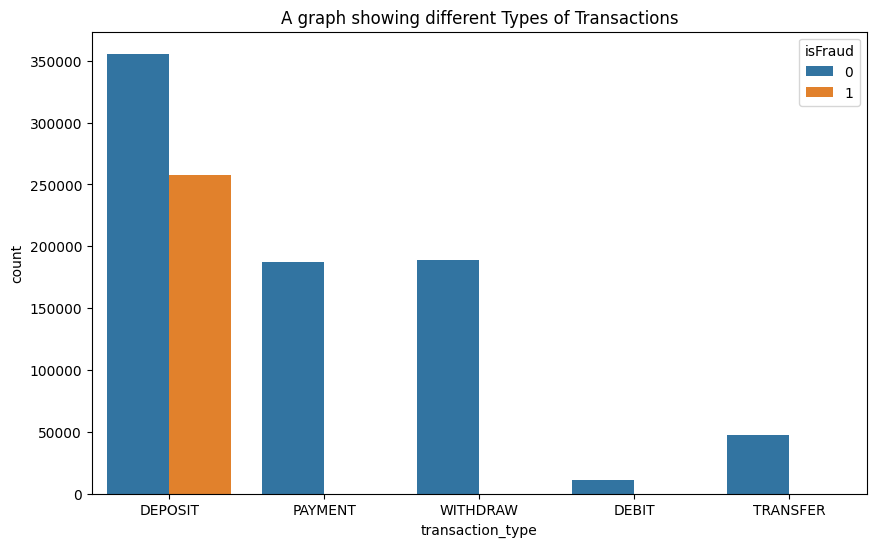

In [12]:
# A hisotgram to show the various fraudulent and non fraudulent results of each transaction type
plt.figure(figsize=(10,6))
transaction_type = sns.countplot(x='transaction_type',hue='isFraud', data=df)
plt.title('A graph showing different Types of Transactions')
with PdfPages('transaction_type.pdf') as pdf:
    pdf.savefig()
plt.show()

In [13]:
# A dataframe to show transaction types column and the isFraud column
df_split_fraud = df[['transaction_type','isFraud']]

df_split_fraud.head()


,transaction_type,isFraud
0,DEPOSIT,1
1,DEPOSIT,1
2,DEPOSIT,1
3,DEPOSIT,1
4,DEPOSIT,1


In [14]:
total_counts = df[df_split_fraud['transaction_type'] == "DEPOSIT"].value_counts()

total_counts_sum = total_counts.sum()
print(f"The sum of the total counts of the transaction types is {total_counts_sum}.")

The sum of the total counts of the transaction types is 613480.


In [15]:
df_split_fraud = df[df_split_fraud['transaction_type'] == "DEPOSIT"]
df_split_fraud.head()

,step,transaction_type,amount,nameOrig,oldBalStartingClient,newBalStartingClient,nameDest,oldBalDestClient,newBalDestClient,isFraud,isFlaggedFraud,isUnauthorizedOverdraft,unnamed
0,0,DEPOSIT,23939.39,4.629230e+15,4925.03,28864.42,76-0004369,0.0,0.0,1,0,0,0
1,0,DEPOSIT,23288.45,4.734790e+15,72.37,23360.82,76-0004369,0.0,0.0,1,0,0,0
2,0,DEPOSIT,23210.04,4.734790e+15,23360.82,46570.86,76-0004369,0.0,0.0,1,0,0,0
3,0,DEPOSIT,23193.08,4.868780e+15,43.00,23236.09,76-0004369,0.0,0.0,1,0,0,0
4,0,DEPOSIT,19029.53,4.218830e+15,86.30,19115.83,76-0004369,0.0,0.0,1,0,0,0


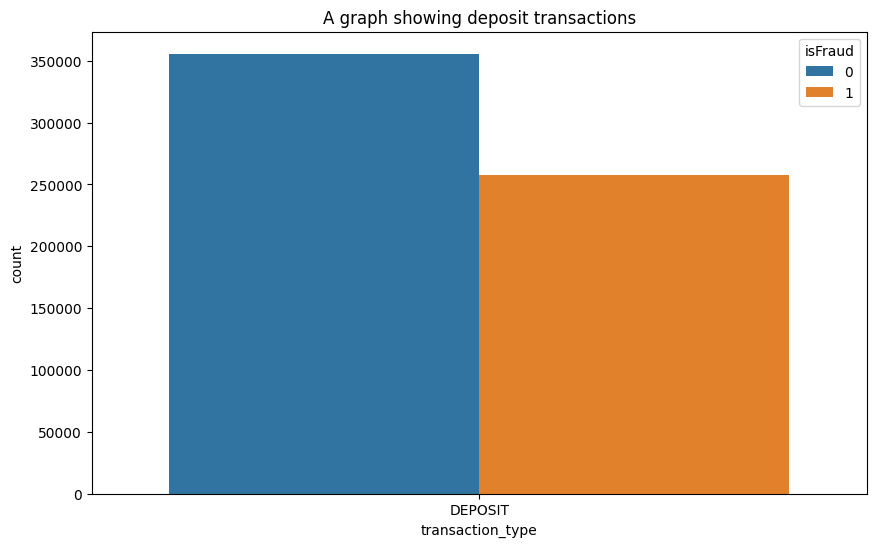

In [16]:
plt.figure(figsize=(10,6))
transaction_type = sns.countplot(x='transaction_type',hue='isFraud', data=df_split_fraud)
plt.title('A graph showing deposit transactions')
with PdfPages('deposit_transaction_type.pdf') as pdf:
    pdf.savefig()
plt.show()

The sum of the total counts of the transaction types is 1048575.
      index  Fraud Percentage  Non-Fraud Percentage
0   DEPOSIT         24.582219             33.923849
1  WITHDRAW               NaN             18.042677
2   PAYMENT               NaN             17.862528
3  TRANSFER               NaN              4.512887
4     DEBIT               NaN              1.075841


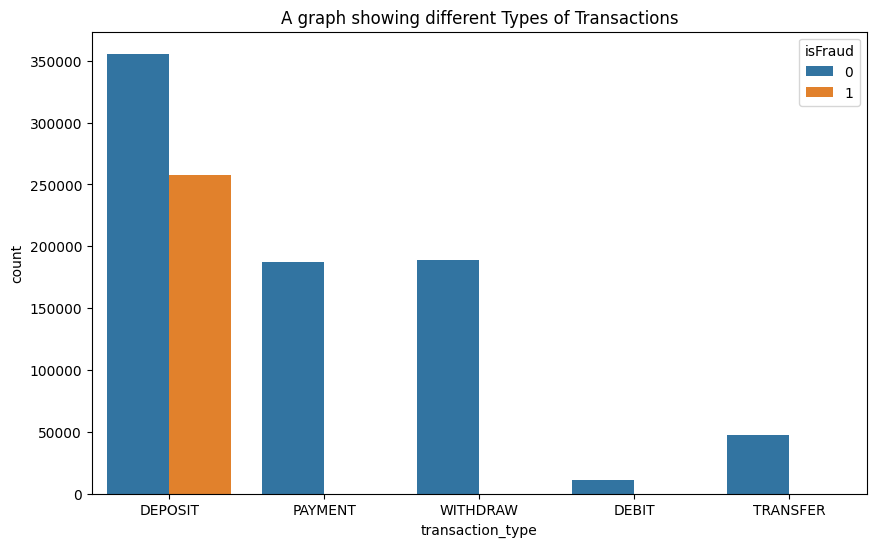

In [17]:
total_counts = df['transaction_type'].value_counts()
total_counts_sum = total_counts.sum()
print(f"The sum of the total counts of the transaction types is {total_counts_sum}.")

# Calculate the count of fraudulent transactions for each transaction type
fraud_counts = df[df['isFraud'] == 1]['transaction_type'].value_counts()


# Calculate the count of non-fraudulent transactions for each transaction type
nonfraud_counts = df[df['isFraud'] == 0]['transaction_type'].value_counts()

# Calculate the percentage of fraudulent transactions for each transaction type
fraud_percentages = (fraud_counts / total_counts_sum) * 100

# Calculate the percentage of non-fraudulent transactions for each transaction type
nonfraud_percentages = (nonfraud_counts / total_counts_sum) * 100

# Combine the fraud_percentages and nonfraud_percentages into a single dataframe
results_df = pd.concat([fraud_percentages, nonfraud_percentages], axis=1)

# Rename the columns to Fraud Percentage and Non-Fraud Percentage
results_df.columns = ['Fraud Percentage', 'Non-Fraud Percentage']

# Reset the index to add the Transaction Type column back
results_df = results_df.reset_index()
print(results_df)
# # Set the style of the plot
# sns.set(style="whitegrid")

# Add percentage values on top of the bars
total = len(df)  # Total number of transactions
for p in transaction_type.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_counts_sum)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    transaction_type.annotate(percentage, (x, y), ha='center')


In [18]:
# Count class labels
df_split_fraud['isFraud'].value_counts()

0    355717
1    257763
Name: isFraud, dtype: int64

In [19]:
# drop the unnamed and id columns.
columns= ['unnamed','transaction_type','nameDest','isFlaggedFraud', 'isUnauthorizedOverdraft']

df_split_fraud = df_split_fraud.drop(columns, axis=1)
df_split_fraud.head()


,step,amount,nameOrig,oldBalStartingClient,newBalStartingClient,oldBalDestClient,newBalDestClient,isFraud
0,0,23939.39,4.629230e+15,4925.03,28864.42,0.0,0.0,1
1,0,23288.45,4.734790e+15,72.37,23360.82,0.0,0.0,1
2,0,23210.04,4.734790e+15,23360.82,46570.86,0.0,0.0,1
3,0,23193.08,4.868780e+15,43.00,23236.09,0.0,0.0,1
4,0,19029.53,4.218830e+15,86.30,19115.83,0.0,0.0,1


In [20]:
# drop the step, nameOrig and id columns.
columns= ['step','nameOrig','isFraud']

new_df = df_split_fraud.drop(columns, axis=1)
new_df.describe().round(3)


,amount,oldBalStartingClient,newBalStartingClient,oldBalDestClient,newBalDestClient
count,613480.000,6.134800e+05,6.134800e+05,613480.000,613480.000
mean,89773.766,3.344515e+06,3.434289e+06,266941.730,266941.730
std,83450.138,1.848548e+06,1.830555e+06,201635.434,201635.434
min,1.910,-1.905846e+05,-1.577926e+05,0.000,0.000
25%,20137.760,2.376716e+06,2.482574e+06,78552.608,78552.608
50%,50642.825,3.286535e+06,3.381086e+06,250434.280,250434.280
75%,147137.632,4.107429e+06,4.191721e+06,442491.530,442491.530
max,595520.690,2.585318e+07,2.587167e+07,869724.740,869724.740


In [21]:
# no of rows and columns
df_split_fraud.shape

(613480, 8)

In [22]:
# Checking the data types
df_split_fraud.dtypes

step                      int64
amount                  float64
nameOrig                float64
oldBalStartingClient    float64
newBalStartingClient    float64
oldBalDestClient        float64
newBalDestClient        float64
isFraud                   int64
dtype: object

In [23]:
# Count class labels
df_split_fraud['isFraud'].value_counts()

0    355717
1    257763
Name: isFraud, dtype: int64

### Data **visualization**

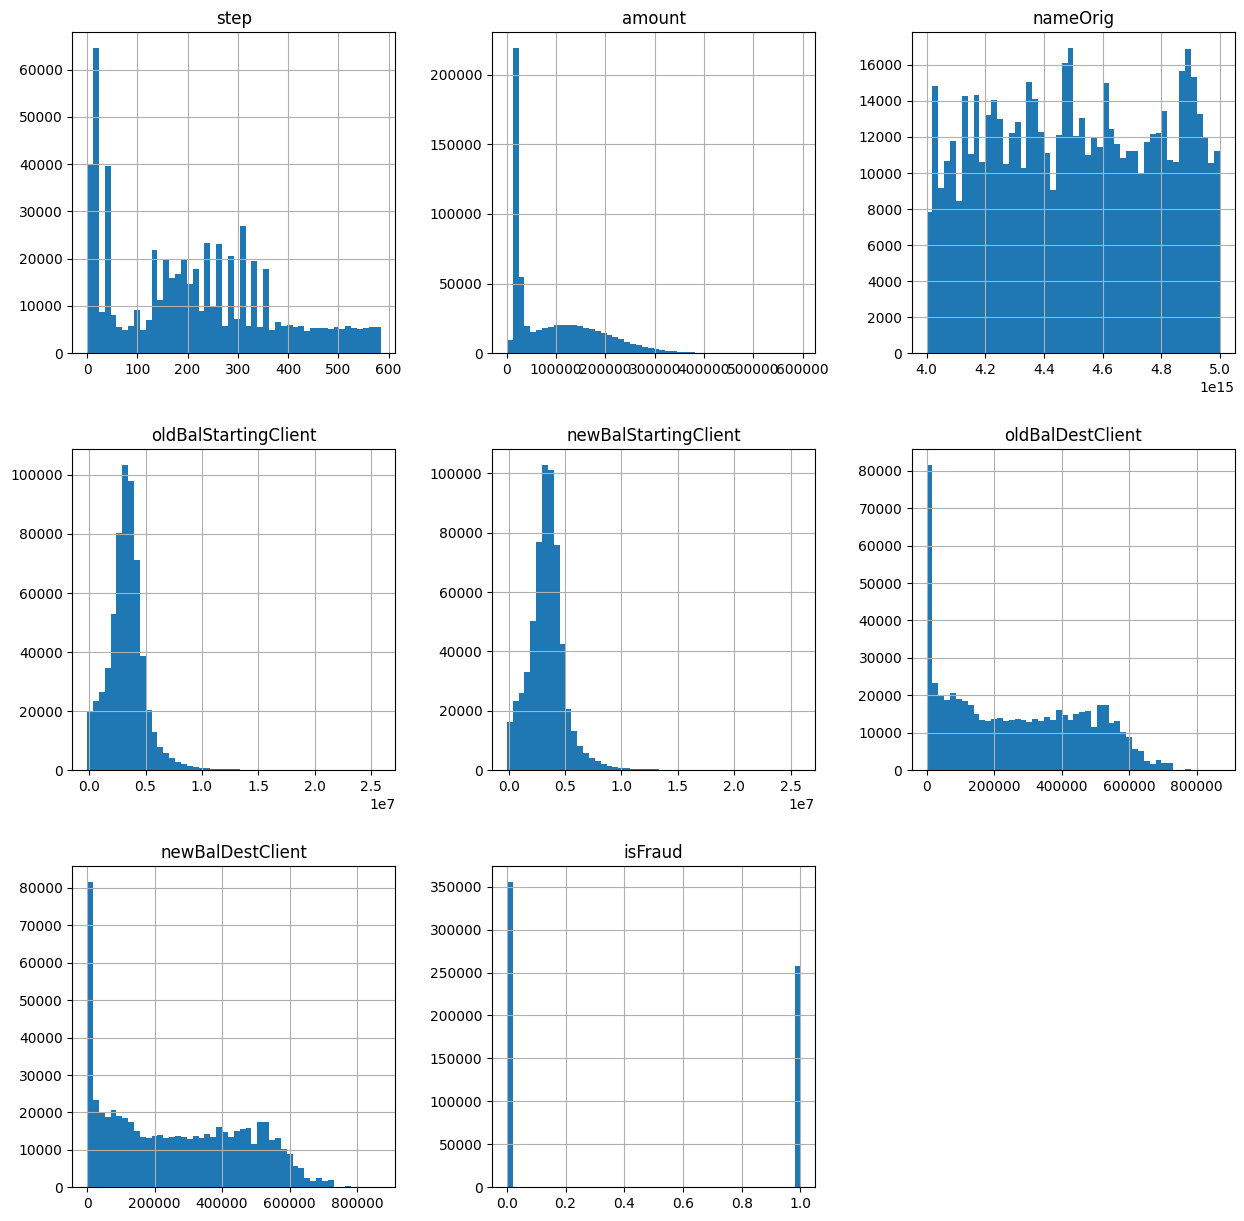

In [24]:
# Data visualization to create histogram
data_visulization = df_split_fraud.hist(bins=50, figsize=(15, 15))
with PdfPages('data_visulization.pdf') as pdf:
    pdf.savefig()
plt.show()

In [25]:
from sklearn.preprocessing import MinMaxScaler

# Creating an Object of StandardScaler
scaler = MinMaxScaler()

# Fit the dataframe to the scaler
print(scaler.fit(df_split_fraud))

MinMaxScaler()


In [26]:
# Transform the dataframe
features_scaled = scaler.transform(df_split_fraud)

# Convertin the scaled array to dataframe
features_scaled = pd.DataFrame(features_scaled, columns=df_split_fraud.columns)
features_scaled.shape
features_scaled.head()


,step,amount,nameOrig,oldBalStartingClient,newBalStartingClient,oldBalDestClient,newBalDestClient,isFraud
0,0.0,0.040196,0.629192,0.007507,0.007171,0.0,0.0,1.0
1,0.0,0.039103,0.734766,0.007321,0.006960,0.0,0.0,1.0
2,0.0,0.038971,0.734766,0.008215,0.007851,0.0,0.0,1.0
3,0.0,0.038943,0.868773,0.007320,0.006955,0.0,0.0,1.0
4,0.0,0.031951,0.218738,0.007321,0.006796,0.0,0.0,1.0


In [27]:
column_mean = features_scaled['amount'].mean()
print(column_mean)

0.15074563365591406


In [28]:
features_scaled.describe().round(3)

,step,amount,nameOrig,oldBalStartingClient,newBalStartingClient,oldBalDestClient,newBalDestClient,isFraud
count,613480.000,613480.000,613480.000,613480.000,613480.000,613480.000,613480.000,613480.000
mean,0.365,0.151,0.508,0.136,0.138,0.307,0.307,0.420
std,0.271,0.140,0.285,0.071,0.070,0.232,0.232,0.494
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.080,0.034,0.261,0.099,0.101,0.090,0.090,0.000
50%,0.351,0.085,0.502,0.134,0.136,0.288,0.288,0.000
75%,0.534,0.247,0.762,0.165,0.167,0.509,0.509,1.000
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


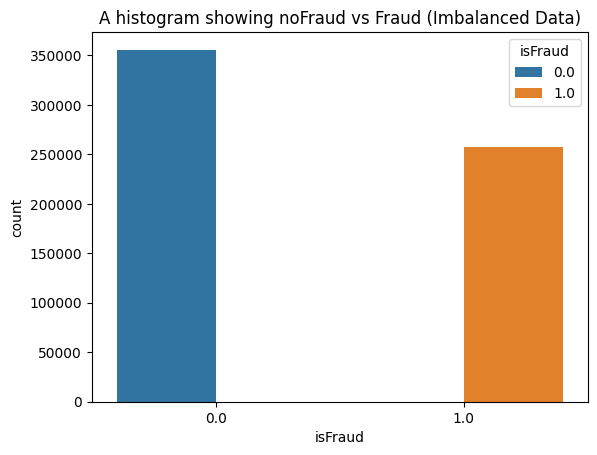

In [29]:
# Count each label
ax = sns.countplot(x='isFraud', data=features_scaled, hue='isFraud')
plt.title('A histogram showing noFraud vs Fraud (Imbalanced Data)')
with PdfPages('Imbalanced.pdf') as pdf:
    pdf.savefig()

In [30]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE
# Instantiate the SMOTE object
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to your feature data and labels
X_resampled, y_resampled = smote.fit_resample(features_scaled, features_scaled['isFraud'])

# Now, X_resampled contain the resampled data with balanced classes.


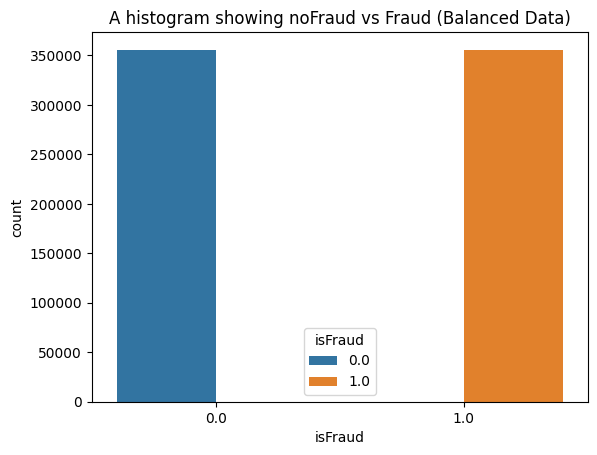

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a countplot to visualize the balanced data
ax = sns.countplot(x='isFraud', data=X_resampled, hue='isFraud')
plt.title('A histogram showing noFraud vs Fraud (Balanced Data)')
with PdfPages('Balanced.pdf') as pdf:
    pdf.savefig()
# Show the plot
plt.show()


<Axes: >

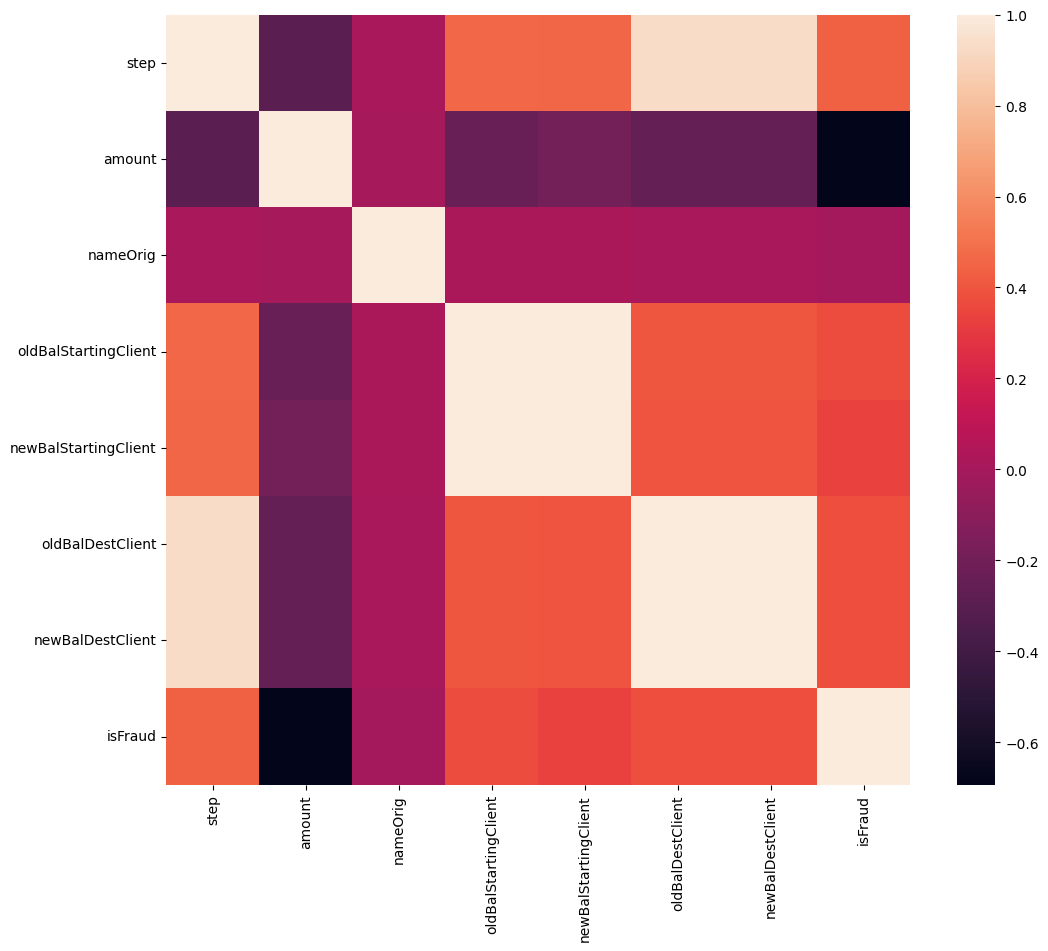

In [32]:
# Finding correlation
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_split_fraud.corr(), ax=ax)

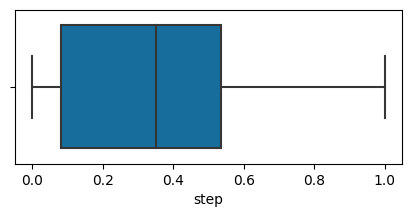

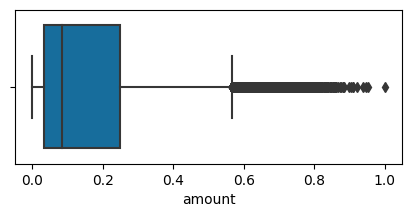

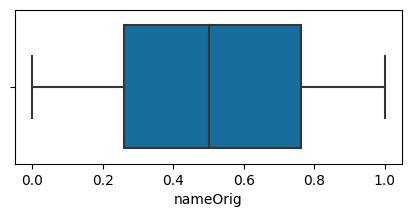

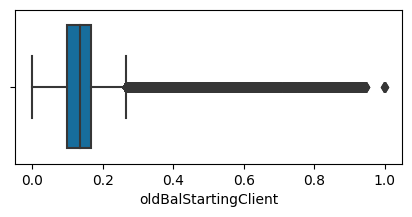

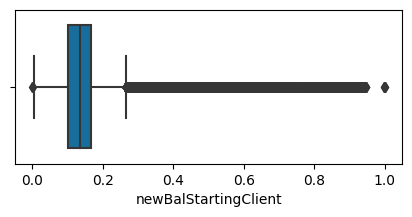

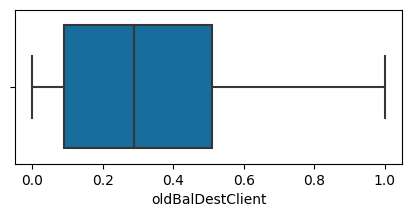

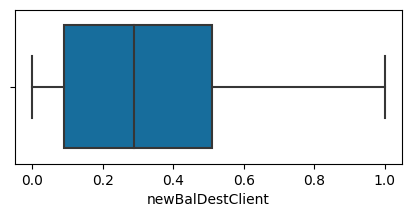

In [33]:
# box plot to check outlier in each category
def boxPlot(dff):
    d = dff.drop(columns=['isFraud'])
    for column in d:
        plt.figure(figsize=(5, 2))
        sns.boxplot(x=column, data=d, palette="colorblind")

boxPlot(features_scaled)

In [41]:
# Separate labels and features
X = features_scaled.drop(columns=['isFraud'])
y = features_scaled['isFraud']

In [42]:
# Spilt the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# we used 30% test data
# check the size before beginning
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((429436, 7), (184044, 7), (429436,), (184044,))

****************************************************
LogisticRegression
Training Set Accuracy: 0.9397232649335407
Test Set Accuracy: 0.9406228945252222 ROC: 0.9457117256480273
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.95    106851
         1.0       0.89      0.98      0.93     77193

    accuracy                           0.94    184044
   macro avg       0.94      0.95      0.94    184044
weighted avg       0.94      0.94      0.94    184044

Cross-validation Results:
   fit_time  score_time  accuracy  precision    recall  f1_score  \
0  1.551285    0.179117  0.937896   0.886567  0.977350  0.929747   
1  0.880767    0.121005  0.940108   0.891688  0.976131  0.932001   
2  0.829634    0.121691  0.939642   0.890629  0.976353  0.931523   
3  0.858690    0.122599  0.941109   0.891963  0.978457  0.933210   
4  0.898916    0.122686  0.935917   0.886003  0.972753  0.927353   
5  0.808726    0.122136  0.939829   0.89

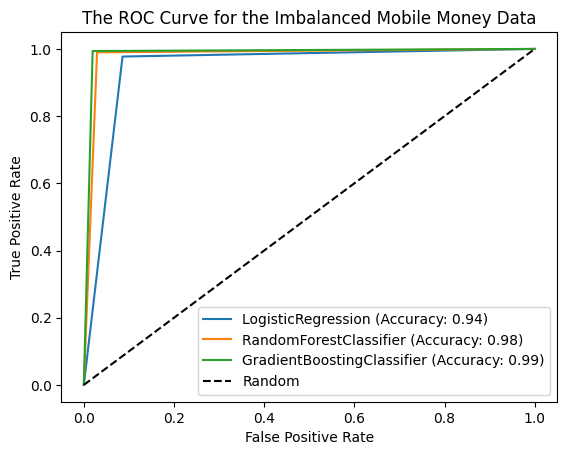

In [43]:
# Define the models
models = [
    LogisticRegression(),
    RandomForestClassifier(n_estimators=20, max_depth=10),
    GradientBoostingClassifier(n_estimators=20, max_depth=10)
]

# Define scoring metric for cross-validation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score),
    'matthews_corrcoef': make_scorer(matthews_corrcoef)
}

# Initialize lists to store results
acc = []
roc = []

# Define function to print cross-validation results
def print_result(result):
    df = pd.DataFrame(result)
    df = df.rename(columns=lambda x: x.replace('test_', ''))
    print(df)

# Execute the code for each model
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    ac = accuracy_score(y_test, y_pred)
    acc.append(ac)
    ac_train = accuracy_score(y_train, y_pred_train)
    rc = roc_auc_score(y_test, y_pred)
    roc.append(rc)
    print("****************************************************")
    print(type(model).__name__)
    print("Training Set Accuracy:", ac_train)
    print("Test Set Accuracy: {0} ROC: {1}".format(ac, rc))

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Cross-validation
    result = cross_validate(model, X_train, y_train, scoring=scoring, cv=10)
    print("Cross-validation Results:")
    print_result(result)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label=f"{type(model).__name__} (Accuracy: {ac:.2f})")


# Set plot attributes
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC Curve for the Imbalanced Mobile Money Data')
plt.legend()

# Create a PDF to save the plot
with PdfPages('roc_curve.pdf') as pdf:
    pdf.savefig()

# Print the model, accuracy, and AUC scores
results_df = pd.DataFrame({
    'Model': [type(model).__name__ for model in models],
    'Accuracy': acc,
    'AUC': roc
})
print(results_df)


In [39]:
# Separate labels and features
X_bal = X_resampled.drop(columns=['isFraud'])
y_bal = X_resampled['isFraud']

# Spilt the train and test data
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3)
# we used 30% test data
# check the size before beginning
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((498003, 7), (213431, 7), (498003,), (213431,))

****************************************************
LogisticRegression
Training Set Accuracy: 0.9466187954691035
Test Set Accuracy: 0.9466431774203372 ROC: 0.9467878101406828
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.91      0.94    107107
         1.0       0.91      0.99      0.95    106324

    accuracy                           0.95    213431
   macro avg       0.95      0.95      0.95    213431
weighted avg       0.95      0.95      0.95    213431

Cross-validation Results:
   fit_time  score_time  accuracy  precision    recall  f1_score  \
0  1.166771    0.137243  0.944640   0.910507  0.986407  0.946939   
1  1.251022    0.146217  0.946708   0.913592  0.986929  0.948845   
2  1.225415    0.137075  0.947712   0.915817  0.986247  0.949728   
3  1.118963    0.135783  0.946747   0.914765  0.985485  0.948809   
4  1.279590    0.140133  0.948474   0.915747  0.988011  0.950507   
5  1.213292    0.135620  0.948153   0.91

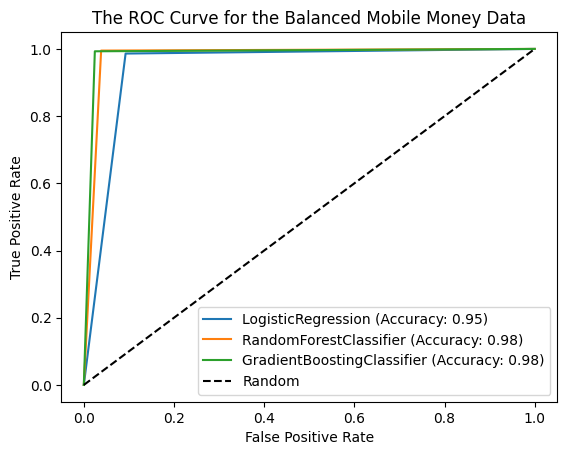

In [40]:
# Define the models
models = [
    LogisticRegression(),
    RandomForestClassifier(n_estimators=20, max_depth=10),
    GradientBoostingClassifier(n_estimators=20, max_depth=10)
]

# Define scoring metric for cross-validation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score),
    'matthews_corrcoef': make_scorer(matthews_corrcoef)
}

# Initialize lists to store results
acc = []
roc = []

# Define function to print cross-validation results
def print_result(result):
    df = pd.DataFrame(result)
    df = df.rename(columns=lambda x: x.replace('test_', ''))
    print(df)

# Execute the code for each model
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    ac = accuracy_score(y_test, y_pred)
    acc.append(ac)
    ac_train = accuracy_score(y_train, y_pred_train)
    rc = roc_auc_score(y_test, y_pred)
    roc.append(rc)
    print("****************************************************")
    print(type(model).__name__)
    print("Training Set Accuracy:", ac_train)
    print("Test Set Accuracy: {0} ROC: {1}".format(ac, rc))

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Cross-validation
    result = cross_validate(model, X_train, y_train, scoring=scoring, cv=10)
    print("Cross-validation Results:")
    print_result(result)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label=f"{type(model).__name__} (Accuracy: {ac:.2f})")


# Set plot attributes
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC Curve for the Balanced Mobile Money Data')
plt.legend()

# Create a PDF to save the plot
with PdfPages('roc_curve2.pdf') as pdf:
    pdf.savefig()

# Print the model, accuracy, and AUC scores
results_df = pd.DataFrame({
    'Model': [type(model).__name__ for model in models],
    'Accuracy': acc,
    'AUC': roc
})
print(results_df)
